In [1]:
# Select the TensorFlow 2.0 runtime
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
# Install Weights and Biases (WnB)
#!pip install wandb

In [3]:
# Primary imports
import tensorflow as tf
import numpy as np
import wandb

In [4]:
# Authorize Weights and Biases
#!wandb login 4e7d76ee685364972c13971b14bddd4e939ca0c6

In [5]:
# Intialize WnB with a project name of your choice
#wandb.init(project="tf_book_ch3_custom_tf_training_loops_wnb")

In [6]:
# Load the FashionMNIST dataset, scale the pixel values
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train/255.
X_test = X_test/255.

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [7]:
# Define the labels of the dataset
CLASSES=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [8]:
# Change the pixel values to float32 and reshape input data
X_train = X_train.astype("float32").reshape(-1, 28, 28, 1)
X_test = X_test.astype("float32").reshape(-1, 28, 28, 1)

In [9]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [10]:
# TensorFlow imports
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

In [11]:
# Define utility function for building a basic shallow Convnet 
def get_training_model():
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation="relu",
        input_shape=(28, 28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (5, 5), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(len(CLASSES), activation="softmax"))
    
    return model

In [12]:
# Define loass function and optimizer
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [13]:
# Average the loss across the batch size within an epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="test_loss")

# Specify the performance metric
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="train_acc")
valid_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="valid_acc")

In [41]:
# Average the loss across the batch size within an epoch
train_loss_adadelta = tf.keras.metrics.Mean(name="train_loss")
valid_loss_adadelta = tf.keras.metrics.Mean(name="test_loss")

# Specify the performance metric
train_acc_adadelta = tf.keras.metrics.SparseCategoricalAccuracy(name="train_acc")
valid_acc_adadelta = tf.keras.metrics.SparseCategoricalAccuracy(name="valid_acc")

In [42]:
# Batches of 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

In [43]:
# Train the model
@tf.function
def model_train(features, labels):
    # Define the GradientTape context
    with tf.GradientTape() as tape:
        # Get the probabilities
        predictions = model(features)
        # Calculate the loss
        loss = loss_func(labels, predictions)
    # Get the gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # Update the weights
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Update the loss and accuracy
    train_loss(loss)
    train_acc(labels, predictions)

In [44]:
# Validating the model
@tf.function
def model_validate(features, labels):
    predictions = model(features)
    v_loss = loss_func(labels, predictions)

    valid_loss(v_loss)
    valid_acc(labels, predictions)
    print(valid_loss)
    print(valid_acc)

In [45]:
optimizer_adadelta = tf.keras.optimizers.Adadelta()

In [46]:
# Train the model
@tf.function
def model_train_adadelta(features, labels):
    # Define the GradientTape context
    with tf.GradientTape() as tape:
        # Get the probabilities
        predictions = model(features)
        # Calculate the loss
        loss = loss_func(labels, predictions)
    # Get the gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # Update the weights
    optimizer_adadelta.apply_gradients(zip(gradients, model.trainable_variables))

    # Update the loss and accuracy
    train_loss_adadelta(loss)
    train_acc_adadelta(labels, predictions)

In [47]:
# Validating the model
@tf.function
def model_validate_adadelta(features, labels):
    predictions = model(features)
    v_loss = loss_func(labels, predictions)

    valid_loss_adadelta(v_loss)
    valid_acc_adadelta(labels, predictions)

In [48]:
# A shallow Convnet
model = get_training_model()

In [49]:
# Grab random images from the test and make predictions using 
# the model *while it is training* and log them using WnB
def get_sample_predictions():
    predictions = []
    images = []
    random_indices = np.random.choice(X_test.shape[0], 25)
    for index in random_indices:
        image = X_test[index].reshape(1, 28, 28, 1)
        prediction = np.argmax(model(image).numpy(), axis=1)
        prediction = CLASSES[int(prediction)]
        
        images.append(image)
        predictions.append(prediction)
    
    #wandb.log({"predictions": [wandb.Image(image, caption=prediction) 
    #                           for (image, prediction) in zip(images, predictions)]})

In [160]:
import pandas as pd
history = pd.DataFrame(columns=['epoch', 'adam_loss', 'adam_acc', 'adam_val_loss', 'adam_val_acc',
                                'adadelta_loss', 'adadelta_acc', 
                                'adadelta_val_loss', 'adadelta_val_acc'])

In [161]:
# Train the model for 5 epochs
for epoch in range(100):
    # Run the model through train and test sets respectively
    for (features, labels) in train_ds:
        model_train(features, labels)
        model_train_adadelta(features, labels)

    for test_features, test_labels in test_ds:
        model_validate(test_features, test_labels)
        model_validate_adadelta(test_features, test_labels)
        
    # Grab the results
    (loss, acc) = train_loss.result(), train_acc.result()
    (val_loss, val_acc) = valid_loss.result(), valid_acc.result()
    
    (loss_adelta, acc_adelta) = train_loss_adadelta.result(), train_acc_adadelta.result()
    (val_loss_adelta, val_acc_adelta) = valid_loss_adadelta.result(), valid_acc_adadelta.result()
    
    # Clear the current state of the metrics
    train_loss.reset_states(), train_acc.reset_states()
    valid_loss.reset_states(), valid_acc.reset_states()
    train_loss_adadelta.reset_states(), train_acc_adadelta.reset_states()
    valid_loss_adadelta.reset_states(), valid_acc_adadelta.reset_states()
    
    # Local logging
    t = "{:.3f}"
    history = history.append({'epoch': epoch, 'adam_loss': t.format(loss), 'adam_acc': t.format(acc),
                              'adam_val_loss':t.format(val_loss),
                             'adam_val_acc':t.format(val_acc),
                             'adadelta_loss': t.format(loss_adelta), 'adadelta_acc': t.format(acc_adelta),
                              'adadelta_val_loss':t.format(val_loss_adelta),
                             'adadelta_val_acc':t.format(val_acc_adelta)
                             
                             }, 
                             ignore_index=True)
    template = "Epoch {}, loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}"
   
    #print (template.format(epoch+1,
    #                     loss,
    #                     acc,
    #                     val_loss,
    #                     val_acc))
    
    # Logging with WnB
    #wandb.log({"train_loss": loss.numpy(),
    #           "train_accuracy": acc.numpy(),
    #           "val_loss": val_loss.numpy(),
    #           "val_accuracy": val_acc.numpy()
    #})
    #get_sample_predictions()

In [162]:
history

,epoch,adam_loss,adam_acc,adam_val_loss,adam_val_acc,adadelta_loss,adadelta_acc,adadelta_val_loss,adadelta_val_acc
0,0,0.022,0.993,1.345,0.894,0.009,0.997,1.345,0.894
1,1,0.018,0.994,1.336,0.894,0.007,0.998,1.336,0.894
2,2,0.024,0.993,1.350,0.895,0.009,0.998,1.350,0.895
3,3,0.023,0.994,1.352,0.894,0.008,0.998,1.352,0.894
4,4,0.017,0.995,1.339,0.898,0.006,0.998,1.339,0.898
...,...,...,...,...,...,...,...,...,...
95,95,0.015,0.996,1.768,0.900,0.004,0.999,1.768,0.900
96,96,0.016,0.996,1.872,0.898,0.004,0.999,1.872,0.898
97,97,0.018,0.996,1.752,0.901,0.005,0.999,1.752,0.901
98,98,0.008,0.997,1.871,0.894,0.002,1.000,1.871,0.894


In [163]:
history.to_csv('multiple_optimizers.csv')

In [166]:
#history['adam_loss'].tolist()

0.008
1.872


<Figure size 432x288 with 0 Axes>

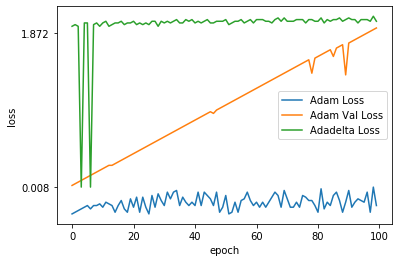

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_history(history):
  hist = history
  hist['epoch'] = history.epoch

  plt.figure()
  fig, ax = plt.subplots()
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.plot(hist['adam_loss'].tolist(),
           label='Adam Loss')
  plt.plot(hist['adam_val_loss'].tolist(),
           label = 'Adam Val Loss')
  plt.plot(hist['adadelta_loss'].tolist(),
           label = 'Adadelta Loss')
  #plt.plot(hist['adadelta_val_loss'].tolist(),
  #         label = 'Adadelta Val Loss')

    #
  #plt.ylim([0,5])
  #plt.gca().invert_yaxis()
  _max =max( max(hist['adam_loss'].tolist()), 
             max(hist['adam_val_loss'].tolist()) 
           )
  _min =min( min(hist['adam_loss'].tolist()), 
             min(hist['adam_val_loss'].tolist())
           )
  print(_min)
  print(_max)
  ax.set_yticks([_min,_max])
  plt.legend()

  plt.show()

plot_history(history)